# Magma Movement Activity
OOI Data Labs Workshop - July 2019

Revised Nov 7, 2019

**Working Title**: Magma Movement and the Shape of the Seafloor

**Short Description**: 
Explore how earthquake data helps explain changes in the topography of an underwater volcano.

In [1]:
# Notebook Setup
import requests
import os
import re
import xarray as xr
import dask
! pip install netcdf4==1.5.0
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Setup default plot styles
import seaborn as sns
sns.set()

## 1. Request Data from OOINet
* **Instrument:** RS03CCAL-MJ03F-05-BOTPTA301
  * Cabled Axial Seamount Array - Central Caldera - Medium-Power JBox (MJ03F) - Bottom Pressure and Tilt
* **Time range:** 24 March 2015 to 24 May 2015


In [0]:
def request_data(reference_designator,method,stream,start_date=None,end_date=None):
  site = reference_designator[:8]
  node = reference_designator[9:14]
  instrument = reference_designator[15:]
  
  # Create the request URL
  api_base_url = 'https://ooinet.oceanobservatories.org/api/m2m/12576/sensor/inv'
  data_request_url ='/'.join((api_base_url,site,node,instrument,method,stream))

  # All of the following are optional, but you should specify a date range
  params = {
    'format':'application/netcdf',
    'include_provenance':'true',
    'include_annotations':'true'
  }
  if (start_date):
    params['beginDT'] = start_date
  if (end_date):
    params['endDT'] = end_date

  # Make the data request
  r = requests.get(data_request_url, params=params, auth=(API_USERNAME, API_TOKEN))
  data = r.json()
  
  # Return just the THREDDS URL
  return data['allURLs'][0] 

In [0]:
API_USERNAME = ''
API_TOKEN = ''

In [0]:
# Data Requests
# request_data('RS03CCAL-MJ03F-05-BOTPTA301','streamed','botpt_nano_sample',
#              '2015-03-24T00:00:00.000Z','2015-05-24T00:00:00.000Z')

## 2. Load Data Files
* Unfortunately, the 15s data product is still not available. So we have to go with the raw 20Hz data, which will require downsampling.

In [0]:
url = 'https://opendap.oceanobservatories.org/thredds/catalog/ooi/sage@marine.rutgers.edu/20191105T185647436Z-RS03CCAL-MJ03F-05-BOTPTA301-streamed-botpt_nano_sample/catalog.html'

In [0]:
def get_datafiles(url,bad_inst=''):
  '''Function to grab all data from specified directory'''
  tds_url = 'https://opendap.oceanobservatories.org/thredds/dodsC'
  datasets = requests.get(url).text
  urls = re.findall(r'href=[\'"]?([^\'" >]+)', datasets)
  x = re.findall(r'(ooi/.*?.nc)', datasets)
  for i in x:
    if i.endswith('.nc') == False:
      x.remove(i)
  for i in x:
    try:
      float(i[-4])
    except:
      x.remove(i)
  datasets = [os.path.join(tds_url, i) for i in x]
  
  # Remove extraneous files if necessary
  selected_datasets = []
  for d in datasets:
    if (bad_inst) and bad_inst in d:
      pass
    elif 'ENG000' in d: #Remove engineering streams for gliders
      pass
    else:
      selected_datasets.append(d)
  return sorted(selected_datasets)

In [7]:
# List of files
files = get_datafiles(url)
files

['https://opendap.oceanobservatories.org/thredds/dodsC/ooi/sage@marine.rutgers.edu/20191105T185647436Z-RS03CCAL-MJ03F-05-BOTPTA301-streamed-botpt_nano_sample/deployment0001_RS03CCAL-MJ03F-05-BOTPTA301-streamed-botpt_nano_sample_20150324T000000-20150331T235959.950000.nc',
 'https://opendap.oceanobservatories.org/thredds/dodsC/ooi/sage@marine.rutgers.edu/20191105T185647436Z-RS03CCAL-MJ03F-05-BOTPTA301-streamed-botpt_nano_sample/deployment0001_RS03CCAL-MJ03F-05-BOTPTA301-streamed-botpt_nano_sample_20150401T000000-20150408T235959.950000.nc',
 'https://opendap.oceanobservatories.org/thredds/dodsC/ooi/sage@marine.rutgers.edu/20191105T185647436Z-RS03CCAL-MJ03F-05-BOTPTA301-streamed-botpt_nano_sample/deployment0001_RS03CCAL-MJ03F-05-BOTPTA301-streamed-botpt_nano_sample_20150409T000000-20150416T235959.950000.nc',
 'https://opendap.oceanobservatories.org/thredds/dodsC/ooi/sage@marine.rutgers.edu/20191105T185647436Z-RS03CCAL-MJ03F-05-BOTPTA301-streamed-botpt_nano_sample/deployment0001_RS03CCAL-MJ

In [8]:
%%time
# Loop through each file and downsample
avgtime = '1H'
num = 1
data = False
for ifile in files:
  print('Downsampling file {} of {}'.format(str(num), str(len(files))))
  num=num+1
  ds = xr.open_dataset(ifile)
  ds = ds.swap_dims({'obs': 'time'})
  ds_avg = ds.bottom_pressure.load().resample({'time':avgtime}).mean().to_dataset()
  if(isinstance(data,xr.Dataset)):
    print('Append')
    data = xr.concat([data, ds_avg],dim='time')
  else:
    print('New')
    data = ds_avg
  ds.close()

print('Complete!')

Downsampling file 1 of 8
New
Downsampling file 2 of 8
Append
Downsampling file 3 of 8
Append
Downsampling file 4 of 8
Append
Downsampling file 5 of 8
Append
Downsampling file 6 of 8
Append
Downsampling file 7 of 8
Append
Downsampling file 8 of 8
Append
Complete!
CPU times: user 33.2 s, sys: 4.19 s, total: 37.4 s
Wall time: 18min 17s


In [9]:
# Save the averaged data
data.to_netcdf('botpt_avg'+avgtime+'.nc')

/usr/local/lib/python3.6/dist-packages/xarray/coding/times.py:240: FutureWarning: the 'box' keyword is deprecated and will be removed in a future version. Please take steps to stop the use of 'box'
  dates = pd.to_datetime(dates, box=False)


/usr/local/lib/python3.6/dist-packages/pandas/plotting/_matplotlib/converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


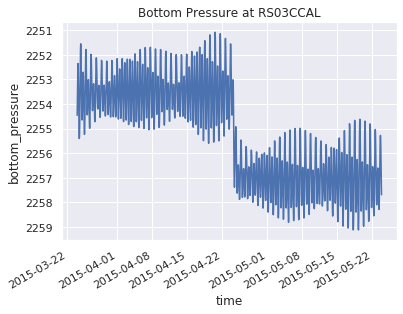

In [10]:
# Quickplot
data.bottom_pressure.plot();
plt.gca().invert_yaxis()
plt.title('Bottom Pressure at RS03CCAL');
plt.savefig('RS03CCAL_pressure.png')

## 3. Detiding
For more information on the using the UTide library, check out this [example](https://nbviewer.jupyter.org/github/wesleybowman/UTide/blob/master/notebooks/utide_real_data_example.ipynb).

In [11]:
!pip install utide
import utide

In [0]:
obs = data.to_dataframe()

# Calculate mean depth and anomoly
mean_depth = obs['bottom_pressure'].mean()
obs['anomaly'] = obs['bottom_pressure'] - mean_depth

In [0]:
# Convert time for UTide
import matplotlib.dates as mdates
time = mdates.date2num(obs.index.to_pydatetime())

In [14]:
coef = utide.solve(time, obs['anomaly'].values,
             lat=45.95484,
             nodal=False,
             trend=False,
             method='ols',
             conf_int='linear',
             Rayleigh_min=0.95,)
tide = utide.reconstruct(time, coef)

solve: matrix prep ... solution ... diagnostics ... done.
prep/calcs ... done.


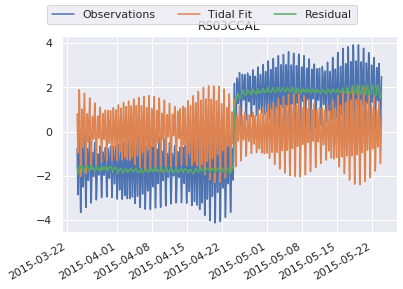

In [15]:
# Single plot
fig,ax = plt.subplots()
ax.plot(tide.t_mpl, obs.anomaly, label='Observations', color='C0')
ax.plot(tide.t_mpl, tide.h, label='Tidal Fit', color='C1')
ax.plot(tide.t_mpl, obs.anomaly - tide.h, label='Residual', color='C2')
ax.xaxis_date()
fig.legend(ncol=3, loc='upper center')
fig.autofmt_xdate()
plt.title('RS03CCAL');
plt.savefig('RS03CCAL_pressure_tidefit.png')

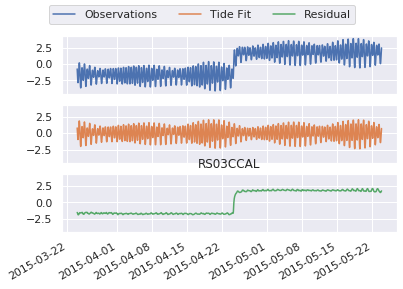

In [16]:
# Three Plots
t = tide.t_mpl
fig, (ax0, ax1, ax2) = plt.subplots(nrows=3, sharey=True, sharex=True)
ax0.plot(t, obs.anomaly, label=u'Observations', color='C0')
ax1.plot(t, tide.h, label=u'Tide Fit', color='C1')
ax2.plot(t, obs.anomaly - tide.h, label=u'Residual', color='C2')
ax2.xaxis_date()
fig.legend(ncol=3, loc='upper center')
fig.autofmt_xdate()
plt.title('RS03CCAL');

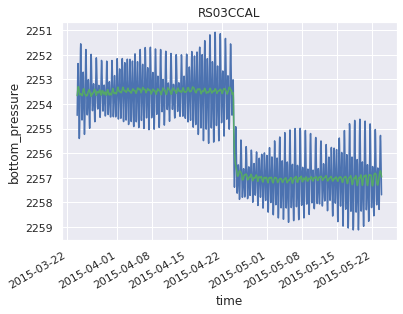

In [17]:
# Detided Plot 
data.bottom_pressure.plot();
plt.plot(tide.t_mpl, obs.anomaly - tide.h + mean_depth, label='Detided Pressure', color='C2')
plt.gca().invert_yaxis()
plt.title('RS03CCAL');
plt.savefig('RS03CCAL_pressure_detided.png')

## 4. Merge and export

In [35]:
x = data
x['Detided'] = obs.anomaly - tide.h + mean_depth
x['Tidal'] = xr.DataArray(tide.h + mean_depth,dims={'time':data.time})
x = x.to_dataframe()
x.head()

,bottom_pressure,Tidal,Detided
time,,,
2015-03-24 00:00:00,2254.461426,2256.011533,2253.657168
2015-03-24 01:00:00,2253.829346,2255.439703,2253.596918
2015-03-24 02:00:00,2253.140625,2254.855860,2253.492041
2015-03-24 03:00:00,2252.595215,2254.413770,2253.388721
2015-03-24 04:00:00,2252.355957,2254.238857,2253.324376


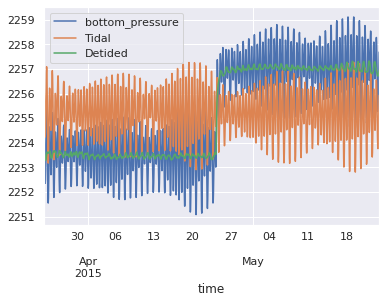

In [39]:
# Quickplot
x.plot();

In [0]:
# Export to CSV
x.to_csv('RS03CCAL.csv')

## Chadwick Data

In [18]:
chadwick = pd.read_csv('MJ03D-NANO-15min-Jan15-Aug15-2015.csv',sep='\s\s+',header=None,names=['Pressure','Depth','Temperature'],parse_dates=True)
chadwick.head()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  """Entry point for launching an IPython kernel.


,Pressure,Depth,Temperature
2015-01-15 00:00:00,2257.1169,1512.6874,3.294956
2015-01-15 00:15:00,2257.1984,1512.6880,3.293849
2015-01-15 00:30:00,2257.2850,1512.6901,3.296199
2015-01-15 00:45:00,2257.3659,1512.6878,3.297457
2015-01-15 01:00:00,2257.4447,1512.6841,3.297174


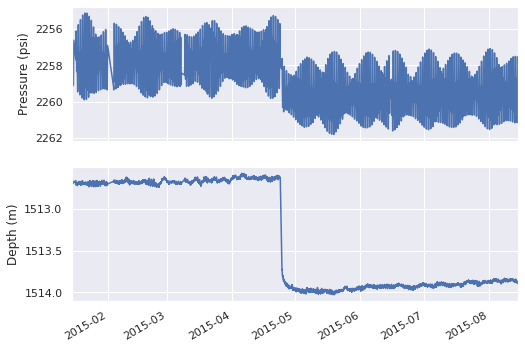

In [19]:
fig,(ax1,ax2) = plt.subplots(2,1,sharex=True,figsize=(8,6))
chadwick.Pressure.plot(ax=ax1)
chadwick.Depth.plot(ax=ax2)
ax1.set_ylabel('Pressure (psi)')
ax2.set_ylabel('Depth (m)')
ax1.invert_yaxis()
ax2.invert_yaxis()
plt.savefig('RS03CCAL_chadwick.png')

It turns out that Bill already provided me with a datafile with the detided/filtered depth data, as well as the raw pressure signal.  In fact, it is better than the detiding above.

## Questions
* Is an hourly average ok, or do we want higher resolution data?
* The detiding above isn't a nice as Bill Chadwick's dataset, I'm assuming you'd prefer to use his data. Turns out, his dataset has both raw pressure and detided/filtered depth.
* Not sure of the best way to convert pressure to depth.